In [1]:
#!/usr/bin/python3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
# import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# ================= CONSTANTS =================
PMT_PULSE_LENGTH = 1500  # Sample lenght of a typical pulse

# Loading dataset

In [3]:
#No normalization is required
#Loading isolated pulses (not long traces)
df = pd.read_csv("../PeakDetection_test_Na22.csv", index_col = 0)

In [4]:
dfPulses = df.copy()
dfPulses

0  1  2  3  4  5  6  7  8  9  ...  1491  1492  1493  1494  1495  1496  \
1     0  0  0  0  1  0  1  0  0  0  ...     0     0     0     0     0     1   
2     1  0  0  0  1  0  1  0  1  0  ...     0     0     0     1     0     0   
3     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
9     0  0  0  0  0  0  0  0  0  0  ...     1     0     0     0     1     0   
13    0  0  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
9907  0  0  0  0  1  0  0  0  0  0  ...    11     9     4     2     3     1   
9911  0  0  1  0  1  0  0  0  1  0  ...     0     1     0     1     0     0   
9912  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     1   
9915  0  1 -1  0  0  1 -1  0 -1  1  ...     1    -1     0    -1     0    -1   
9919  0  0  0  0  1  0  0  0  1  0  ...     0     1     6    11     0     1   

      1497  1498  1499                                      peakLocations  
1        0     0     0  [6, 14, 31, 41, 45, 50, 63, 76, 88, 94, 99, 10...  
2        0     0     0  [4, 12, 83, 114, 143, 175, 253, 437, 538, 661,...  
3        0     0     0  [6, 14, 22, 33, 42, 51, 62, 67, 72, 84, 95, 10...  
9        1     0     1  [11, 23, 39, 50, 58, 89, 102, 108, 113, 119, 1...  
13       0     0     0  [5, 8, 11, 15, 28, 42, 48, 66, 71, 98, 126, 13...  
...    ...   ...   ...                                                ...  
9907     0     1     0  [6, 13, 20, 27, 37, 40, 48, 57, 80, 89, 93, 96...  
9911     0     0     0  [4, 42, 49, 64, 92, 123, 184, 191, 289, 293, 3...  
9912     0     0     0  [6, 24, 28, 37, 46, 66, 70, 80, 113, 139, 193,...  
9915     0     1     9  [5, 8, 14, 28, 35, 44, 48, 57, 63, 72, 83, 89,...  
9919     0     0     0  [5, 8, 14, 23, 36, 42, 59, 68, 71, 78, 94, 103...  

[2781 rows x 1501 columns]

# Peak detection and valid pulse filtering algorithms

In [5]:
def pkdetect(x, thr=100, pkh=10):
    peak=[]
    lmax=0
    imax=0
    count=0
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lmax:
            imax=i
            lmax=x[i]
        elif ((lmax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peak.append(imax)
            lmax=0
        else:
            pass
            
    return peak

# ===== DEBUGGING TEST - DO NOT RUN =======

In [6]:
samplePulse = dfPulses.iloc[20]
samplePulse

0                                                                0
1                                                                0
2                                                                0
3                                                                1
4                                                                0
                                       ...                        
1496                                                             0
1497                                                             0
1498                                                             0
1499                                                             1
peakLocations    [6, 22, 31, 37, 44, 49, 59, 62, 75, 84, 92, 95...
Name: 60, Length: 1501, dtype: object

In [7]:
%matplotlib notebook
x = samplePulse.loc["peakLocations"]
y = samplePulse[x]

BASELINE_SHIFT = 2

for i in range(1000):
    samplePulse = dfPulses.iloc[i]
    x = samplePulse.loc["peakLocations"]
    y = []
    
    
    for j in range(len(x)):
        y.append(samplePulse[x[j]] - samplePulse[x[j - BASELINE_SHIFT]])
    
    plt.plot(x,y, 'r+', alpha = 0.4)

plt.show()

KeyError: '[6, 22, 31, 37, 44, 49, 59, 62, 75, 84, 92, 95, 100, 110, 116, 131, 137, 143, 160, 186, 209, 214, 228, 243, 256, 260, 273, 312, 361, 375, 385, 399, 429, 436, 447, 500, 535, 547, 565, 594, 641, 671, 679, 762, 796, 831, 1168, 1196]'

In [28]:
dfPulses

0   1   2   3   4   5   6   7   8   9  ...  1493  1494  1495  1496  \
7       41  30  30  25  15  22  41  63  91  91  ...     2     2     2     2   
10       1   2  44  34  30  37  53  70  71  88  ...     2     2     4     6   
11       6   3   2   4   1   3   2   3   2   3  ...     2     1     2     1   
12      11   6   2   5   2   2  11  18  14  11  ...     3     1     3     1   
40       2   2   2   3   1   4  14  20  14  12  ...     3     2     3     1   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
156991  26  19  14   9   7   8  18  31  29  21  ...     2     1     3     2   
156993  10   6   6   4   3   3   3  10  19  19  ...     1     2     1     2   
157015  58  36  31  18  11  12  21  26  33  39  ...     2     3     2     2   
157019   7   6   3   3   2   4   2   3   9  16  ...     3     2     2     2   
157021   3   2   1   3   1   3   3  15  27  28  ...     2     2     3     1   

        1497  1498  1499                                      peakLocations  \
7          2     3     2  [1, 8, 23, 26, 31, 39, 66, 69, 94, 117, 122, 1...   
10         9    22    37  [2, 11, 22, 32, 41, 51, 55, 73, 76, 80, 93, 10...   
11         2     2     2  [19, 50, 72, 114, 143, 173, 184, 239, 266, 350...   
12         2     1     2                                      [7, 195, 273]   
40         3     1     3  [7, 37, 161, 221, 267, 361, 373, 399, 408, 443...   
...      ...   ...   ...                                                ...   
156991     2     2     2  [1, 7, 13, 26, 31, 40, 49, 54, 57, 68, 74, 83,...   
156993     1     2     1  [13, 18, 22, 31, 42, 64, 99, 121, 139, 164, 17...   
157015     1     1     1  [1, 13, 21, 31, 39, 45, 57, 61, 71, 80, 91, 11...   
157019     3     1     2  [13, 65, 138, 154, 169, 185, 212, 253, 335, 36...   
157021     2     2     2  [9, 22, 29, 35, 195, 360, 370, 392, 403, 556, ...   

                                             arrivalTimes  \
7       [7, 22, 25, 30, 38, 65, 68, 93, 116, 121, 129,...   
10      [9, 20, 30, 39, 49, 53, 71, 74, 78, 91, 98, 11...   
11      [31, 53, 95, 124, 154, 165, 220, 247, 331, 367...   
12                                             [188, 266]   
40      [30, 154, 214, 260, 354, 366, 392, 401, 436, 4...   
...                                                   ...   
156991  [6, 12, 25, 30, 39, 48, 53, 56, 67, 73, 82, 98...   
156993  [5, 9, 18, 29, 51, 86, 108, 126, 151, 160, 196...   
157015  [12, 20, 30, 38, 44, 56, 60, 70, 79, 90, 111, ...   
157019  [52, 125, 141, 156, 172, 199, 240, 322, 350, 3...   
157021  [13, 20, 26, 186, 351, 361, 383, 394, 547, 640...   

                                         timeBetweenPeaks  
7       [7, 15, 3, 5, 8, 27, 3, 25, 23, 5, 8, 7, 17, 6...  
10      [9, 11, 10, 9, 10, 4, 18, 3, 4, 13, 7, 15, 8, ...  
11      [31, 22, 42, 29, 30, 11, 55, 27, 84, 36, 18, 5...  
12                                              [188, 78]  
40      [30, 124, 60, 46, 94, 12, 26, 9, 35, 28, 154, ...  
...                                                   ...  
156991  [6, 6, 13, 5, 9, 9, 5, 3, 11, 6, 9, 16, 5, 9, ...  
156993  [5, 4, 9, 11, 22, 35, 22, 18, 25, 9, 36, 46, 8...  
157015  [12, 8, 10, 8, 6, 12, 4, 10, 9, 11, 21, 8, 16,...  
157019  [52, 73, 16, 15, 16, 27, 41, 82, 28, 15, 17, 2...  
157021  [13, 7, 6, 160, 165, 10, 22, 11, 153, 93, 7, 1...  

[23979 rows x 1503 columns]

In [26]:
%matplotlib notebook
dfPulses.iloc[1000:1010,:].T.plot()
plt.show()

TypeError: no numeric data to plot

In [213]:
import random
randPulse = random.randrange(len(df))
randPulse

1189

<IPython.core.display.Javascript object>


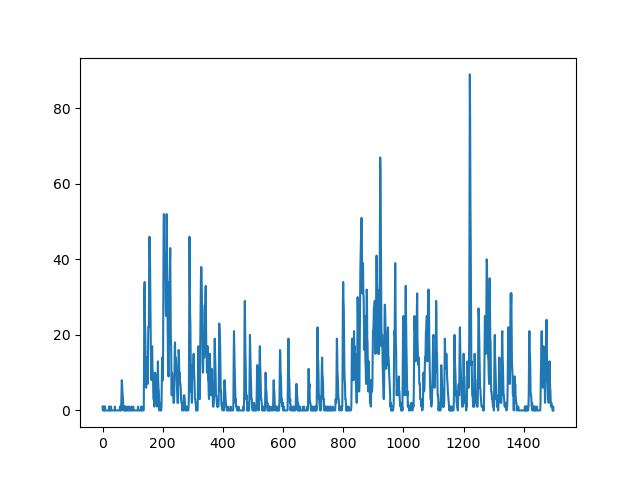

In [214]:
%matplotlib notebook
sample = df.iloc[randPulse,:PMT_PULSE_LENGTH]
sample.plot()
plt.show()
# print("Valid: "+ str(validPulse(sample, 5, 10, 200, 1.25)))

# ===== DEBUGGING ENDS HERE :) =======

# Peaks sequence detection

### Time between first and Nth peaks

In [6]:
def relativeArrivalTimes(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[0]) #Relative time respect to first peak
    
    return deltaList

### Time between successive peaks

In [7]:
def peaksStrToList(currentStrList):
    if type(currentStrList) == str:
        return np.array(currentStrList.replace("[", "").replace("]", "").replace("\n", "").split(",")).astype(int).tolist()
    return currentStrList

In [8]:
def timeBetweenPeaks(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[i]) #Relative time respect to first peak
    
    return deltaList

In [9]:
#Cleaning str-like characters from imported CSV data
dfPulses["peakLocations"] = dfPulses.iloc[:,PMT_PULSE_LENGTH].apply(peaksStrToList)
dfPulses

0  1  2  3  4  5  6  7  8  9  ...  1491  1492  1493  1494  1495  1496  \
1     0  0  0  0  1  0  1  0  0  0  ...     0     0     0     0     0     1   
2     1  0  0  0  1  0  1  0  1  0  ...     0     0     0     1     0     0   
3     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
9     0  0  0  0  0  0  0  0  0  0  ...     1     0     0     0     1     0   
13    0  0  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
9907  0  0  0  0  1  0  0  0  0  0  ...    11     9     4     2     3     1   
9911  0  0  1  0  1  0  0  0  1  0  ...     0     1     0     1     0     0   
9912  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     1   
9915  0  1 -1  0  0  1 -1  0 -1  1  ...     1    -1     0    -1     0    -1   
9919  0  0  0  0  1  0  0  0  1  0  ...     0     1     6    11     0     1   

      1497  1498  1499                                      peakLocations  
1        0     0     0  [6, 14, 31, 41, 45, 50, 63, 76, 88, 94, 99, 10...  
2        0     0     0  [4, 12, 83, 114, 143, 175, 253, 437, 538, 661,...  
3        0     0     0  [6, 14, 22, 33, 42, 51, 62, 67, 72, 84, 95, 10...  
9        1     0     1  [11, 23, 39, 50, 58, 89, 102, 108, 113, 119, 1...  
13       0     0     0  [5, 8, 11, 15, 28, 42, 48, 66, 71, 98, 126, 13...  
...    ...   ...   ...                                                ...  
9907     0     1     0  [6, 13, 20, 27, 37, 40, 48, 57, 80, 89, 93, 96...  
9911     0     0     0  [4, 42, 49, 64, 92, 123, 184, 191, 289, 293, 3...  
9912     0     0     0  [6, 24, 28, 37, 46, 66, 70, 80, 113, 139, 193,...  
9915     0     1     9  [5, 8, 14, 28, 35, 44, 48, 57, 63, 72, 83, 89,...  
9919     0     0     0  [5, 8, 14, 23, 36, 42, 59, 68, 71, 78, 94, 103...  

[2781 rows x 1501 columns]

In [10]:
dfPulses["arrivalTimes"] = dfPulses["peakLocations"].apply(relativeArrivalTimes)
dfPulses

0  1  2  3  4  5  6  7  8  9  ...  1492  1493  1494  1495  1496  1497  \
1     0  0  0  0  1  0  1  0  0  0  ...     0     0     0     0     1     0   
2     1  0  0  0  1  0  1  0  1  0  ...     0     0     1     0     0     0   
3     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
9     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     1     0     1   
13    0  0  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
9907  0  0  0  0  1  0  0  0  0  0  ...     9     4     2     3     1     0   
9911  0  0  1  0  1  0  0  0  1  0  ...     1     0     1     0     0     0   
9912  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     1     0   
9915  0  1 -1  0  0  1 -1  0 -1  1  ...    -1     0    -1     0    -1     0   
9919  0  0  0  0  1  0  0  0  1  0  ...     1     6    11     0     1     0   

      1498  1499                                      peakLocations  \
1        0     0  [6, 14, 31, 41, 45, 50, 63, 76, 88, 94, 99, 10...   
2        0     0  [4, 12, 83, 114, 143, 175, 253, 437, 538, 661,...   
3        0     0  [6, 14, 22, 33, 42, 51, 62, 67, 72, 84, 95, 10...   
9        0     1  [11, 23, 39, 50, 58, 89, 102, 108, 113, 119, 1...   
13       0     0  [5, 8, 11, 15, 28, 42, 48, 66, 71, 98, 126, 13...   
...    ...   ...                                                ...   
9907     1     0  [6, 13, 20, 27, 37, 40, 48, 57, 80, 89, 93, 96...   
9911     0     0  [4, 42, 49, 64, 92, 123, 184, 191, 289, 293, 3...   
9912     0     0  [6, 24, 28, 37, 46, 66, 70, 80, 113, 139, 193,...   
9915     1     9  [5, 8, 14, 28, 35, 44, 48, 57, 63, 72, 83, 89,...   
9919     0     0  [5, 8, 14, 23, 36, 42, 59, 68, 71, 78, 94, 103...   

                                           arrivalTimes  
1     [8, 25, 35, 39, 44, 57, 70, 82, 88, 93, 102, 1...  
2     [8, 79, 110, 139, 171, 249, 433, 534, 657, 773...  
3     [8, 16, 27, 36, 45, 56, 61, 66, 78, 89, 102, 1...  
9     [12, 28, 39, 47, 78, 91, 97, 102, 108, 144, 17...  
13    [3, 6, 10, 23, 37, 43, 61, 66, 93, 121, 129, 1...  
...                                                 ...  
9907  [7, 14, 21, 31, 34, 42, 51, 74, 83, 87, 90, 95...  
9911  [38, 45, 60, 88, 119, 180, 187, 285, 289, 300,...  
9912  [18, 22, 31, 40, 60, 64, 74, 107, 133, 187, 20...  
9915  [3, 9, 23, 30, 39, 43, 52, 58, 67, 78, 84, 88,...  
9919  [3, 9, 18, 31, 37, 54, 63, 66, 73, 89, 98, 103...  

[2781 rows x 1502 columns]

In [11]:
dfPulses["timeBetweenPeaks"] = dfPulses["peakLocations"].apply(timeBetweenPeaks)
dfPulses

0  1  2  3  4  5  6  7  8  9  ...  1493  1494  1495  1496  1497  1498  \
1     0  0  0  0  1  0  1  0  0  0  ...     0     0     0     1     0     0   
2     1  0  0  0  1  0  1  0  1  0  ...     0     1     0     0     0     0   
3     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
9     0  0  0  0  0  0  0  0  0  0  ...     0     0     1     0     1     0   
13    0  0  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
9907  0  0  0  0  1  0  0  0  0  0  ...     4     2     3     1     0     1   
9911  0  0  1  0  1  0  0  0  1  0  ...     0     1     0     0     0     0   
9912  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     1     0     0   
9915  0  1 -1  0  0  1 -1  0 -1  1  ...     0    -1     0    -1     0     1   
9919  0  0  0  0  1  0  0  0  1  0  ...     6    11     0     1     0     0   

      1499                                      peakLocations  \
1        0  [6, 14, 31, 41, 45, 50, 63, 76, 88, 94, 99, 10...   
2        0  [4, 12, 83, 114, 143, 175, 253, 437, 538, 661,...   
3        0  [6, 14, 22, 33, 42, 51, 62, 67, 72, 84, 95, 10...   
9        1  [11, 23, 39, 50, 58, 89, 102, 108, 113, 119, 1...   
13       0  [5, 8, 11, 15, 28, 42, 48, 66, 71, 98, 126, 13...   
...    ...                                                ...   
9907     0  [6, 13, 20, 27, 37, 40, 48, 57, 80, 89, 93, 96...   
9911     0  [4, 42, 49, 64, 92, 123, 184, 191, 289, 293, 3...   
9912     0  [6, 24, 28, 37, 46, 66, 70, 80, 113, 139, 193,...   
9915     9  [5, 8, 14, 28, 35, 44, 48, 57, 63, 72, 83, 89,...   
9919     0  [5, 8, 14, 23, 36, 42, 59, 68, 71, 78, 94, 103...   

                                           arrivalTimes  \
1     [8, 25, 35, 39, 44, 57, 70, 82, 88, 93, 102, 1...   
2     [8, 79, 110, 139, 171, 249, 433, 534, 657, 773...   
3     [8, 16, 27, 36, 45, 56, 61, 66, 78, 89, 102, 1...   
9     [12, 28, 39, 47, 78, 91, 97, 102, 108, 144, 17...   
13    [3, 6, 10, 23, 37, 43, 61, 66, 93, 121, 129, 1...   
...                                                 ...   
9907  [7, 14, 21, 31, 34, 42, 51, 74, 83, 87, 90, 95...   
9911  [38, 45, 60, 88, 119, 180, 187, 285, 289, 300,...   
9912  [18, 22, 31, 40, 60, 64, 74, 107, 133, 187, 20...   
9915  [3, 9, 23, 30, 39, 43, 52, 58, 67, 78, 84, 88,...   
9919  [3, 9, 18, 31, 37, 54, 63, 66, 73, 89, 98, 103...   

                                       timeBetweenPeaks  
1     [8, 17, 10, 4, 5, 13, 13, 12, 6, 5, 9, 3, 23, ...  
2     [8, 71, 31, 29, 32, 78, 184, 101, 123, 116, 9,...  
3     [8, 8, 11, 9, 9, 11, 5, 5, 12, 11, 13, 11, 8, ...  
9     [12, 16, 11, 8, 31, 13, 6, 5, 6, 36, 29, 29, 1...  
13    [3, 3, 4, 13, 14, 6, 18, 5, 27, 28, 8, 6, 8, 9...  
...                                                 ...  
9907  [7, 7, 7, 10, 3, 8, 9, 23, 9, 4, 3, 5, 4, 10, ...  
9911  [38, 7, 15, 28, 31, 61, 7, 98, 4, 11, 6, 5, 8,...  
9912  [18, 4, 9, 9, 20, 4, 10, 33, 26, 54, 17, 12, 8...  
9915  [3, 6, 14, 7, 9, 4, 9, 6, 9, 11, 6, 4, 4, 8, 8...  
9919  [3, 6, 9, 13, 6, 17, 9, 3, 7, 16, 9, 5, 8, 13,...  

[2781 rows x 1503 columns]

# Filtering by energies

In [12]:
dfAreas = pd.read_csv("../PeakDetection_test_Na22_Areas.csv", index_col = 0)
dfAreas

Na22
1      7424
2      1634
3      8869
9      7310
13     6935
...     ...
9907  13482
9911  14505
9912   3791
9915  14537
9919  17652

[2781 rows x 1 columns]

In [13]:
dfPulses = pd.concat([dfPulses, dfAreas], axis = 1)

In [14]:
upperEnergy = 18e3
lowerEnergy = 12e3
dfPulsesFiltered = dfPulses.loc[((dfPulses["Na22"] > lowerEnergy) & (dfPulses["Na22"] < upperEnergy))]
dfPulsesFiltered

0  1  2  3  4  5  6  7  8  9  ...  1494  1495  1496  1497  1498  1499  \
16    0  0  0  0  0  0  0  0  1  0  ...     0     0     0     0     0     0   
17    1  0  0  0  1  0  0  0  1  0  ...     0     0     0     0     1     0   
58    0  0  1  0  1 -1  0  0  0 -1  ...     1    -1     1    -1     1    -1   
66    0  1  0  1 -1  0  0  1  0  1  ...    -1     0     0     0    -1     0   
70    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
9906  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
9907  0  0  0  0  1  0  0  0  0  0  ...     2     3     1     0     1     0   
9911  0  0  1  0  1  0  0  0  1  0  ...     1     0     0     0     0     0   
9915  0  1 -1  0  0  1 -1  0 -1  1  ...    -1     0    -1     0     1     9   
9919  0  0  0  0  1  0  0  0  1  0  ...    11     0     1     0     0     0   

                                          peakLocations  \
16    [6, 14, 20, 26, 42, 49, 59, 63, 76, 80, 90, 95...   
17    [6, 12, 23, 28, 38, 45, 48, 60, 69, 73, 76, 82...   
58    [5, 17, 22, 26, 31, 37, 40, 48, 62, 76, 95, 10...   
66    [6, 15, 21, 28, 36, 42, 45, 53, 64, 79, 84, 92...   
70    [8, 25, 29, 34, 42, 51, 57, 64, 69, 74, 78, 88...   
...                                                 ...   
9906  [5, 9, 24, 28, 31, 35, 38, 44, 52, 76, 84, 96,...   
9907  [6, 13, 20, 27, 37, 40, 48, 57, 80, 89, 93, 96...   
9911  [4, 42, 49, 64, 92, 123, 184, 191, 289, 293, 3...   
9915  [5, 8, 14, 28, 35, 44, 48, 57, 63, 72, 83, 89,...   
9919  [5, 8, 14, 23, 36, 42, 59, 68, 71, 78, 94, 103...   

                                           arrivalTimes  \
16    [8, 14, 20, 36, 43, 53, 57, 70, 74, 84, 89, 94...   
17    [6, 17, 22, 32, 39, 42, 54, 63, 67, 70, 76, 85...   
58    [12, 17, 21, 26, 32, 35, 43, 57, 71, 90, 103, ...   
66    [9, 15, 22, 30, 36, 39, 47, 58, 73, 78, 86, 93...   
70    [17, 21, 26, 34, 43, 49, 56, 61, 66, 70, 80, 8...   
...                                                 ...   
9906  [4, 19, 23, 26, 30, 33, 39, 47, 71, 79, 91, 98...   
9907  [7, 14, 21, 31, 34, 42, 51, 74, 83, 87, 90, 95...   
9911  [38, 45, 60, 88, 119, 180, 187, 285, 289, 300,...   
9915  [3, 9, 23, 30, 39, 43, 52, 58, 67, 78, 84, 88,...   
9919  [3, 9, 18, 31, 37, 54, 63, 66, 73, 89, 98, 103...   

                                       timeBetweenPeaks   Na22  
16    [8, 6, 6, 16, 7, 10, 4, 13, 4, 10, 5, 5, 4, 6,...  14450  
17    [6, 11, 5, 10, 7, 3, 12, 9, 4, 3, 6, 9, 3, 7, ...  13779  
58    [12, 5, 4, 5, 6, 3, 8, 14, 14, 19, 13, 21, 4, ...  13578  
66    [9, 6, 7, 8, 6, 3, 8, 11, 15, 5, 8, 7, 11, 8, ...  16402  
70    [17, 4, 5, 8, 9, 6, 7, 5, 5, 4, 10, 9, 8, 8, 3...  17422  
...                                                 ...    ...  
9906  [4, 15, 4, 3, 4, 3, 6, 8, 24, 8, 12, 7, 7, 10,...  14192  
9907  [7, 7, 7, 10, 3, 8, 9, 23, 9, 4, 3, 5, 4, 10, ...  13482  
9911  [38, 7, 15, 28, 31, 61, 7, 98, 4, 11, 6, 5, 8,...  14505  
9915  [3, 6, 14, 7, 9, 4, 9, 6, 9, 11, 6, 4, 4, 8, 8...  14537  
9919  [3, 6, 9, 13, 6, 17, 9, 3, 7, 16, 9, 5, 8, 13,...  17652  

[1212 rows x 1504 columns]

## Relative time between first and Nth peak

<IPython.core.display.Javascript object>


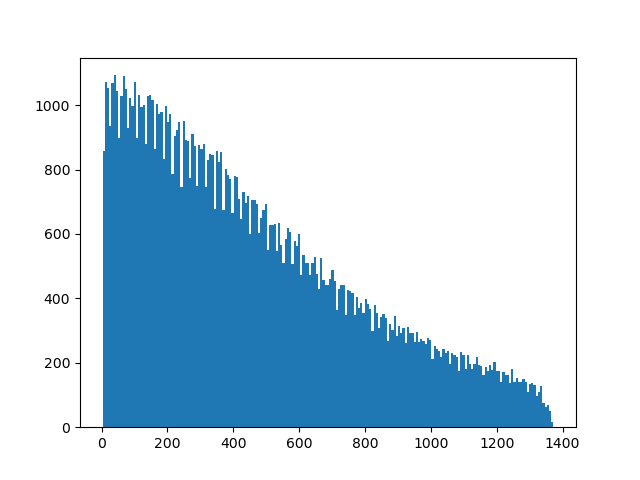

In [15]:
%matplotlib notebook
arrivalTimes = []
for i in dfPulsesFiltered["arrivalTimes"]:
    arrivalTimes.extend(i)

nBinsFit = int(2*(len(arrivalTimes)**(2/5.0)))
# nBinsFit = 50

histData = plt.hist(arrivalTimes, bins = nBinsFit)
plt.show()

In [16]:
nBinsFit

203

# Model fitting
## Finding parameters of exponential distribution for relative times from first peak

In [17]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [18]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [19]:
fittingBoundsAmp = (1000, 100000)
fittingBoundsLam = (1e-6, 1.00)

In [20]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [21]:
distAmp

1188.8707846561956

In [22]:
distLambda

0.001435582024643162

<IPython.core.display.Javascript object>


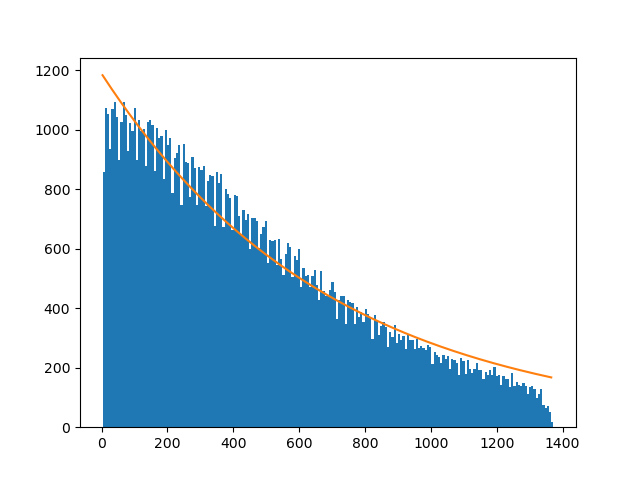

In [23]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(arrivalTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()

In [24]:
len(arrivalTimes)

104408

In [25]:
a = 0
for i in arrivalTimes:
    if (i < 219 and i > 216):
        a += 1

In [26]:
a

274

## Finding parameters of exponential distribution for time between succesive peaks (Poisson)

<IPython.core.display.Javascript object>


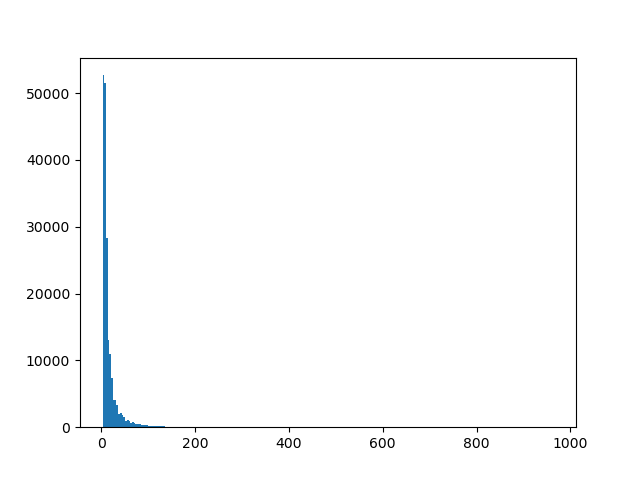

In [27]:
%matplotlib notebook
betweenPulsesTimes = []
for i in dfPulses["timeBetweenPeaks"]:
    betweenPulsesTimes.extend(i)

nBinsFit = int(2*(len(betweenPulsesTimes)**(2/5.0)))
    
histData = plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.show()

In [28]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [29]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [30]:
fittingBoundsAmp = (10000, 500000)
fittingBoundsLam = (1e-6, 1.00)

In [31]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [32]:
distAmp

79321.72217994047

In [33]:
distLambda

0.10231945583458964

<IPython.core.display.Javascript object>


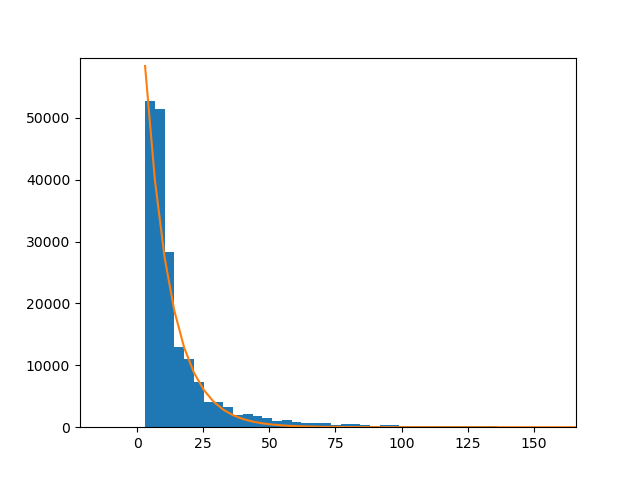

In [34]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()